# Python ML Project

## I. Import libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import csv
from datetime import datetime as dt
from sklearn.model_selection import (train_test_split,cross_val_score,RepeatedStratifiedKFold,RandomizedSearchCV,KFold)
from sklearn.preprocessing import (LabelEncoder,
    RobustScaler,
    OneHotEncoder,
    PolynomialFeatures)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import (RocCurveDisplay,PrecisionRecallDisplay,
    roc_auc_score,
    classification_report,
    confusion_matrix,ConfusionMatrixDisplay,
    fbeta_score,f1_score,recall_score,
)

## II. EDA and feature engineering

### 2.1 Importing data and preprocessing

In [2]:
ddir = '../Data/books.csv'
#ddir = '..\\Data\\books.csv'

#Rows with number of elements not consistent with the number of columns in the header
with open(ddir, encoding="utf8") as fd:
    reader=csv.reader(fd)
    lines = list(reader)
    nbColumns = len(lines[0])
    print("There are {} column names in the header.".format(nbColumns))
    RowsToPrep=[[idx, row] for idx, row in enumerate(lines) if len(row) != nbColumns]
fd.close()

print("There are {} rows with number of elements not consistent with the number of columns in the header of the file.\n".format(len(RowsToPrep)))
for row in RowsToPrep:
    print(row)
#We can see that number of columns inconsistency is due to additionnal comma with the author name(s).
#Let's merge those columns then to not loose data from the dataset

There are 12 column names in the header.
There are 4 rows with number of elements not consistent with the number of columns in the header of the file.

[3349, ['12224', 'Streetcar Suburbs: The Process of Growth in Boston  1870-1900', 'Sam Bass Warner', ' Jr./Sam B. Warner', '3.58', '0674842111', '9780674842113', 'en-US', '236', '61', '6', '4/20/2004', 'Harvard University Press']]
[4703, ['16914', "The Tolkien Fan's Medieval Reader", 'David E. Smith (Turgon of TheOneRing.net', ' one of the founding members of this Tolkien website)/Verlyn Flieger/Turgon (=David E. Smith)', '3.58', '1593600119', '9781593600112', 'eng', '400', '26', '4', '4/6/2004', 'Cold Spring Press']]
[5878, ['22128', 'Patriots (The Coming Collapse)', 'James Wesley', ' Rawles', '3.63', '156384155X', '9781563841552', 'eng', '342', '38', '4', '1/15/1999', 'Huntington House Publishers']]
[8980, ['34889', "Brown's Star Atlas: Showing All The Bright Stars With Full Instructions How To Find And Use Them For Navigational Purpo

In [3]:
#Build the corrected file by duplicating each line without the two problematic column values. Then insert those column values after merging them.
prepDdir = '../Data/books_prep.csv'
#prepDdir = '..\Data\books_prep.csv'

for elt in RowsToPrep:
    prepRows = [a for idx,a in enumerate(elt[1]) if idx not in [2,3]]
    prepRows.insert(2, elt[1][2] + " -" + elt[1][3])
    elt[1] = prepRows
    print("Line {} before preprocessing\n {}".format(elt[0], lines[elt[0]]))
    lines[elt[0]] = prepRows
    print("Line {} after preprocessing\n {}\n".format(elt[0], lines[elt[0]]))

with open(prepDdir, 'w', newline='', encoding="utf8") as file:
    writer = csv.writer(file)
    writer.writerows(lines)
file.close()

Line 3349 before preprocessing
 ['12224', 'Streetcar Suburbs: The Process of Growth in Boston  1870-1900', 'Sam Bass Warner', ' Jr./Sam B. Warner', '3.58', '0674842111', '9780674842113', 'en-US', '236', '61', '6', '4/20/2004', 'Harvard University Press']
Line 3349 after preprocessing
 ['12224', 'Streetcar Suburbs: The Process of Growth in Boston  1870-1900', 'Sam Bass Warner - Jr./Sam B. Warner', '3.58', '0674842111', '9780674842113', 'en-US', '236', '61', '6', '4/20/2004', 'Harvard University Press']

Line 4703 before preprocessing
 ['16914', "The Tolkien Fan's Medieval Reader", 'David E. Smith (Turgon of TheOneRing.net', ' one of the founding members of this Tolkien website)/Verlyn Flieger/Turgon (=David E. Smith)', '3.58', '1593600119', '9781593600112', 'eng', '400', '26', '4', '4/6/2004', 'Cold Spring Press']
Line 4703 after preprocessing
 ['16914', "The Tolkien Fan's Medieval Reader", 'David E. Smith (Turgon of TheOneRing.net - one of the founding members of this Tolkien website)/

In [4]:
df = pd.read_csv(prepDdir,sep=",",index_col="bookID")

##### Check data structure

In [5]:
df.shape

(11127, 11)

In [6]:
df.dtypes

title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

In [5]:
#Remove the extra space in column '  num_pages'
df = df.rename(columns={'  num_pages': 'num_pages'})

##### Checking missing values

In [6]:
df.isna().sum()

title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

##### Look at first and last records

In [9]:
df.head()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [10]:
df.tail()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press
45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books
45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books
45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco
45641,Las aventuras de Tom Sawyer,Mark Twain,3.91,8497646983,9788497646987,spa,272,113,12,5/28/2006,Edimat Libros


In [686]:
##### Possible questions

##### Regression problem : What is the expected rating of a book according to information provided in other columns.
##### Classification problem : What is the expected "rating class" (High or Low/Medium) of a book according to information provided in other columns.

##### Transform date column

In [7]:
#Checking dates before transforming them to be reading as it should
tempDf = df.copy()
publication_date = pd.to_datetime(tempDf['publication_date'],format='%m/%d/%Y', errors='coerce')
print("*** Number of invalid parsing set to NaT: {}.\n".format(publication_date.isna().sum()))

*** Number of invalid parsing set to NaT: 2.



In [8]:
#There are some invalid dates. Let's display the corresponding lines.
tempIndex = list(tempDf.loc[publication_date.isna(),:].index)
print("*** Index of invalid publication dates : {}\n".format(tempIndex))
print("*** Invalid publication dates : {}\n".format(tempDf.loc[publication_date.isna(),['publication_date']]))
print("*** Records with invalid parsing set to NaT in tempDf for publication date : : {}\n".format(df.loc[tempIndex]))

*** Index of invalid publication dates : [31373, 45531]

*** Invalid publication dates :        publication_date
bookID                 
31373        11/31/2000
45531         6/31/1982

*** Records with invalid parsing set to NaT in tempDf for publication date : :                                                     title  \
bookID                                                      
31373   In Pursuit of the Proper Sinner (Inspector Lyn...   
45531          Montaillou  village occitan de 1294 à 1324   

                                                authors  average_rating  \
bookID                                                                    
31373                                 Elizabeth  George            4.10   
45531   Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie            3.96   

              isbn         isbn13 language_code  num_pages  ratings_count  \
bookID                                                                      
31373   0553575104  9780553575101  

In [9]:
#We have only two lines with inconsistence day for the displayed month. Therefore we update the date by the 
#ones retreived on Internet.
#https://www.goodreads.com/book/show/31373.In_Pursuit_of_the_Proper_Sinner?ref=nav_sb_ss_1_13
#https://www.chasse-aux-livres.fr/prix/0553575104/in-pursuit-of-the-proper-sinner-elizabeth-george
#31/10/2000
#"https://www.goodreads.com/book/show/45531
#30/06/1982

#This change will not impact the following results as we are going to focus only on the publication year.

df['publication_date'].replace('11/31/2000', '10/31/2000', inplace=True)
df['publication_date'].replace('6/31/1982', '6/30/1982', inplace=True)

In [10]:
#Check that everything is ok with the dates now.
tempDf = df.copy()
publication_date = pd.to_datetime(tempDf['publication_date'],format='%m/%d/%Y', errors='coerce')
print("*** Number of invalid parsing set to NaT: {}.\n".format(publication_date.isna().sum()))

*** Number of invalid parsing set to NaT: 0.



In [11]:
#As everything is ok now, transform date in the oroginal dataframe column to be reading as it should
df['publication_date']=pd.to_datetime(df['publication_date'],format='%m/%d/%Y')

#create a new variable with the publication date to analize it later
df['publicationYear'] = pd.DatetimeIndex(df['publication_date']).year

In [12]:
#Check isbn13 as object since it is an ID
df['isbn13']=df['isbn13'].astype('object')
#Check of the types after transformation
df.dtypes

title                         object
authors                       object
average_rating               float64
isbn                          object
isbn13                        object
language_code                 object
num_pages                      int64
ratings_count                  int64
text_reviews_count             int64
publication_date      datetime64[ns]
publisher                     object
publicationYear                int32
dtype: object

##### Transform language code column

In [13]:
#checking how many different languages and if it's possible regrouping
df[['language_code','title']].groupby('language_code').count()

,title
language_code,
ale,1
ara,1
en-CA,7
en-GB,214
en-US,1409
eng,8911
enm,3
fre,144
ger,99


In [14]:
#regrouping cathegories
def map_leng_categories(category):
    if category in ["en-CA","en-GB","en-US",'eng']:
        return 'eng'
    elif category in ['fre', 'spa', 'ger', 'jpn']:
        return category
    else:
        return 'other'

# Apply the function, create new column
df['language_code_grouped'] = df['language_code'].apply(map_leng_categories)

df[['language_code_grouped','title']].groupby('language_code_grouped').count()


,title
language_code_grouped,
eng,10541
fre,144
ger,99
jpn,46
other,79
spa,218


##### Transform average rate column to categories (for the classification problem) 

In [15]:
def f(row):
    if row['average_rating'] >= 4.25:
        val = 'HigRat'
    else:
        val = 'LMRat'
    return val

df['catRating'] = df.apply(f, axis=1)

#check the proportion
percentage = df.groupby('catRating')['title'].count().reset_index()
percentage['Percentage'] = 100 * percentage['title']  / percentage['title'].sum()
percentage

,catRating,title,Percentage
0,HigRat,1502,13.498697
1,LMRat,9625,86.501303


### 2.2 Analyzing data 

##### Descriptive statistics

In [16]:
df.select_dtypes(["float64","int64","int32"]).describe()

,average_rating,num_pages,ratings_count,text_reviews_count,publicationYear
count,11127.000000,11127.000000,1.112700e+04,11127.000000,11127.000000
mean,3.933631,336.376921,1.793641e+04,541.854498,2000.167520
std,0.352445,241.127305,1.124794e+05,2576.176608,8.248836
min,0.000000,0.000000,0.000000e+00,0.000000,1900.000000
25%,3.770000,192.000000,1.040000e+02,9.000000,1998.000000
50%,3.960000,299.000000,7.450000e+02,46.000000,2003.000000
75%,4.135000,416.000000,4.993500e+03,237.500000,2005.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000,2020.000000


##### Histogram and kernel density estimate

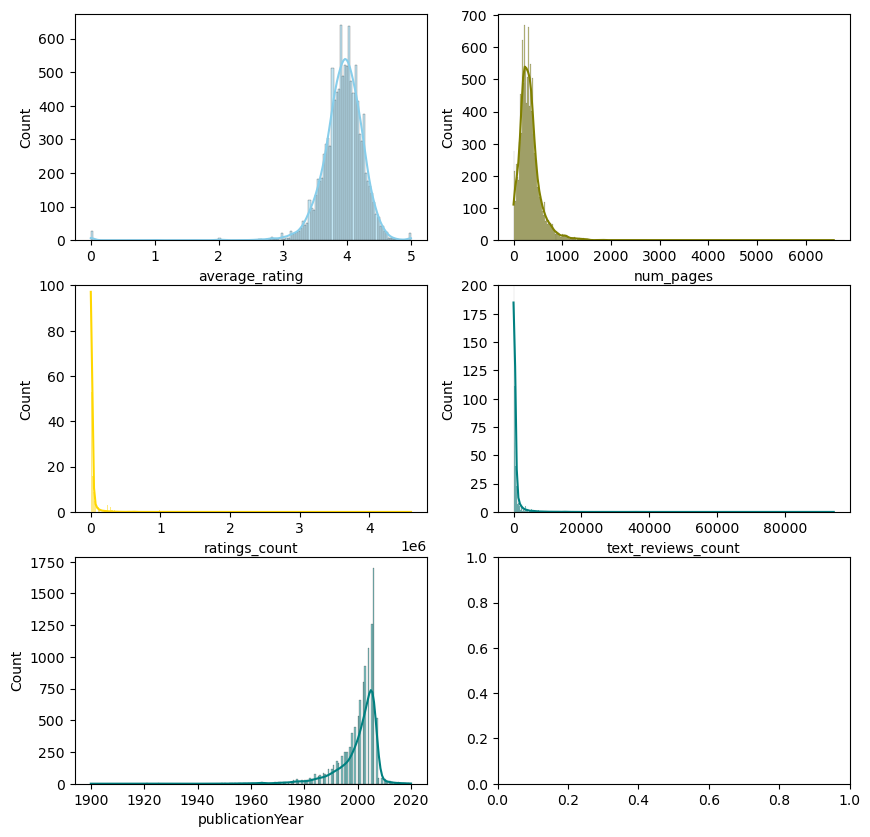

In [55]:
#df.select_dtypes(["float64","int64","int32"]).hist(figsize=(10, 10), bins=20)
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

sns.histplot(data=df, x="average_rating", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="num_pages", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="ratings_count", kde=True, color="gold", ax=axs[1, 0]).set_ylim(0, 100)
sns.histplot(data=df, x="text_reviews_count", kde=True, color="teal", ax=axs[1, 1]).set_ylim(0, 200)
sns.histplot(data=df, x="publicationYear", kde=True, color="teal", ax=axs[2, 0])

plt.show()

##### Histogram for the 'average_rating' by 'language_code_grouped'

<Axes: xlabel='average_rating', ylabel='Count'>

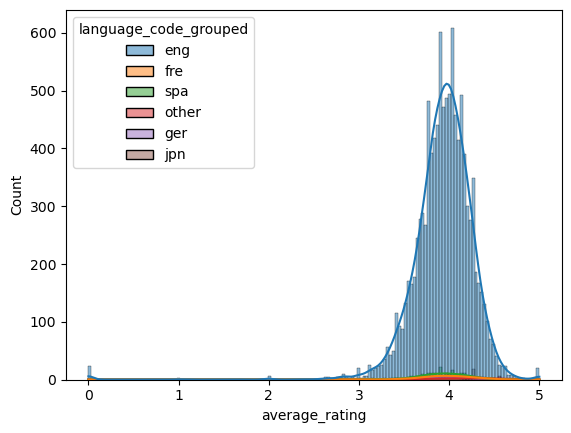

In [21]:
sns.histplot(data=df, x="average_rating", kde=True,hue='language_code_grouped')

##### Boxplot

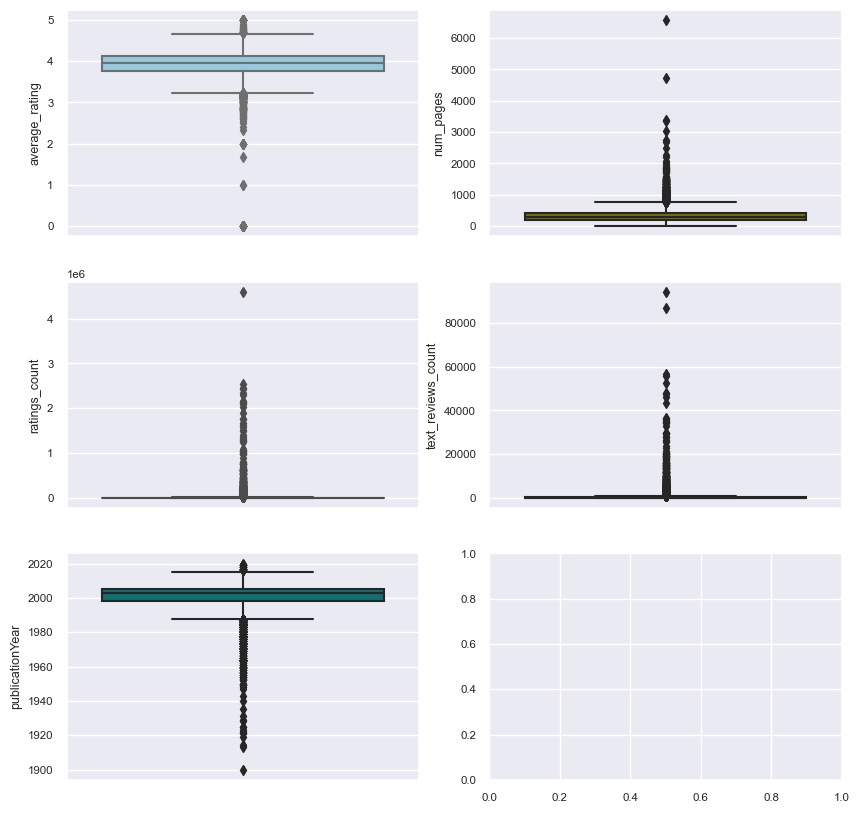

In [24]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

sns.boxplot(data=df, y="average_rating", color="skyblue", ax=axs[0, 0]) #fill=False, 
sns.boxplot(data=df, y="num_pages", color="olive", ax=axs[0, 1])
sns.boxplot(data=df, y="ratings_count", color="gold", ax=axs[1, 0])#.set_ylim(0, 100)
sns.boxplot(data=df, y="text_reviews_count", color="teal", ax=axs[1, 1])#.set_ylim(0, 200)
sns.boxplot(data=df, y="publicationYear", color="teal", ax=axs[2, 0])

plt.show()

##### Boxplot for the 'average_rating' by 'language_code_grouped'

<Axes: xlabel='language_code_grouped', ylabel='average_rating'>

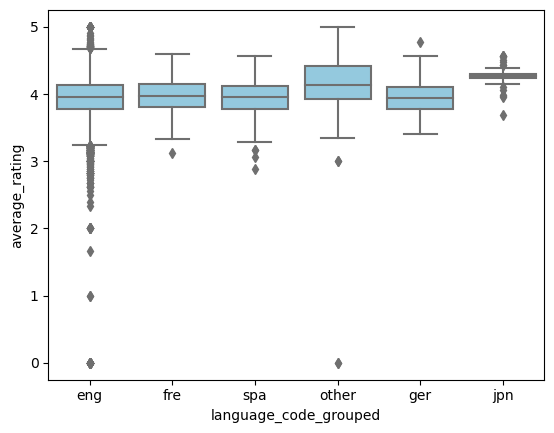

In [22]:
sns.boxplot(data=df, x="language_code_grouped", y="average_rating", color="skyblue")

In [23]:
fig = px.box(df, x="language_code_grouped", y="average_rating", points="all")
fig.show()

##### Correlation matrix

<Axes: >

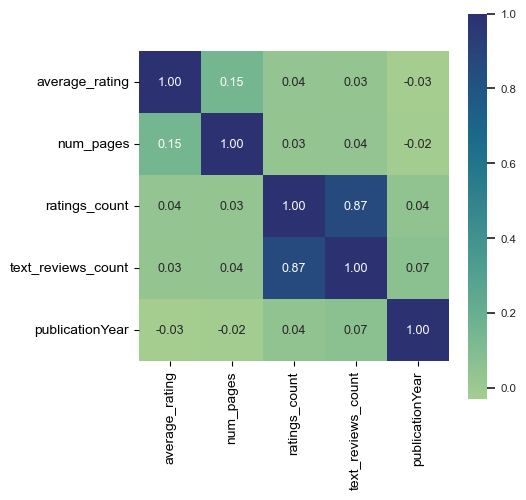

In [25]:
mcorrel = df.select_dtypes(["float64","int64","int32"]).corr(method="pearson")

fig, ax = plt.subplots(figsize=(5, 5))
sns.set(font_scale=0.75)
sns.heatmap(
    mcorrel,
    square=True,
    ax=ax,
    cmap="crest",
    annot=True, fmt=".2f"
)

###### High correlation between ratings_count and text_reviews_count which makes sense as we can expect that when a text has been reviewed, a rate has most probably be provided as well. This also mean that we can keep only one of these two columns for modeling. Many correlations are very low. Therefore, we could expect poor results from linear models (regression problem). 

##### Authors and publisher columns

###### After reviewing the variables and seeing that only a few are available, a treatment is sought for 'authors' and 'publisher' to see if it is possible to include it in the analysis.

In [17]:
#Number of unique authors
print(len(df['authors'].unique()))

#Authors sorted by the number of books written
tempDf = df[['authors','title']].groupby(['authors'])['authors'] \
    .count() \
        .reset_index(name='count') \
            .sort_values(['count'], ascending=False) \
            #.head(100)
tempDf

6643


,authors,count
4750,P.G. Wodehouse,40
5790,Stephen King,40
5473,Rumiko Takahashi,39
4714,Orson Scott Card,35
46,Agatha Christie,33
...,...,...
812,Carolyn Keene/Mildred Benson,1
3066,Joanna Weaver,1
3065,Joanna Strange,1
3064,Joan Sinclair/James Farrer,1


In [27]:
#Most (at least 75%) of authors have actually written only 1 book
print(tempDf.describe())

             count
count  6643.000000
mean      1.674996
std       2.280117
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max      40.000000


<Axes: >

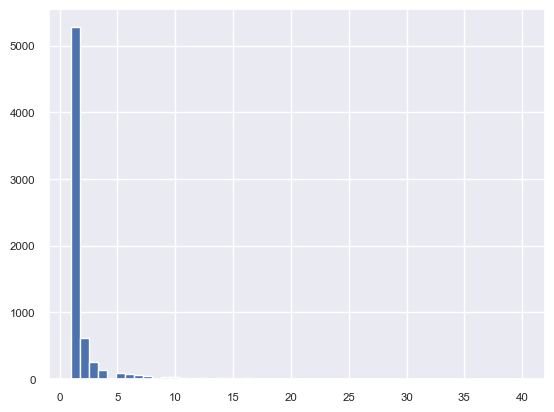

In [28]:
#Histogramme for number of authors depending on number of publications
tempDf['count'].hist(bins=50)

array([[<Axes: title={'center': 'count'}>]], dtype=object)

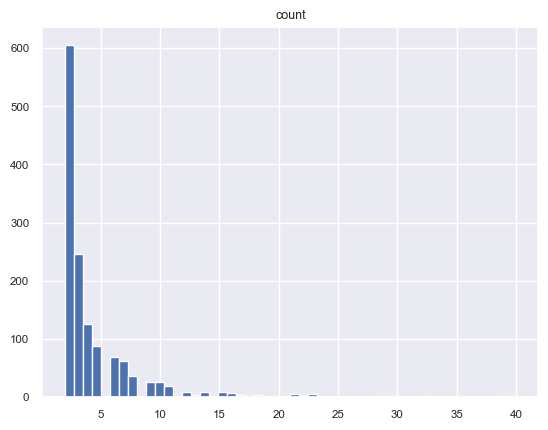

In [707]:
#Histogramme for number of authors depending on number of publications, when they have written more than 1 book
tempDf[tempDf['count'] > 1].hist(bins=50)

       mean_average_rating
count          5282.000000
mean              3.924335
std               0.403375
min               0.000000
25%               3.770000
50%               3.960000
75%               4.140000
max               5.000000
[[<Axes: title={'center': 'mean_average_rating'}>]]


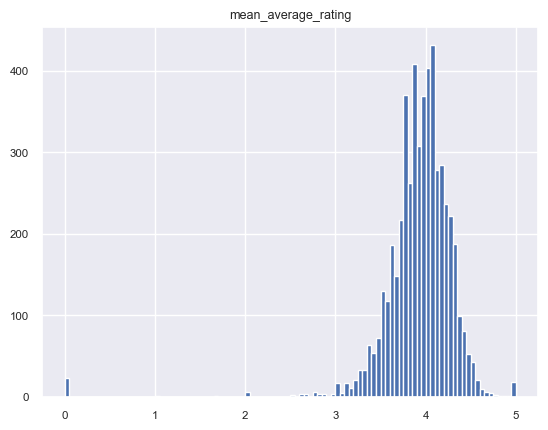

In [30]:
#When we look at how ratings are distributed amoung authors having only one book
#we can see that the ratings are more or less symetrically distributed around the mean (close to the median).

temp = df.copy()
temp2 = temp[['authors','average_rating']].groupby('authors') \
    .agg({'authors':'size', 'average_rating':'mean'}) \
    .rename(columns={'authors':'count','average_rating':'mean_average_rating'}) \

temp2 = temp2[temp2['count']==1][["mean_average_rating"]]
print(temp2.describe())
print(temp2.hist(bins=100))

<Axes: xlabel='count', ylabel='mean_average_rating'>

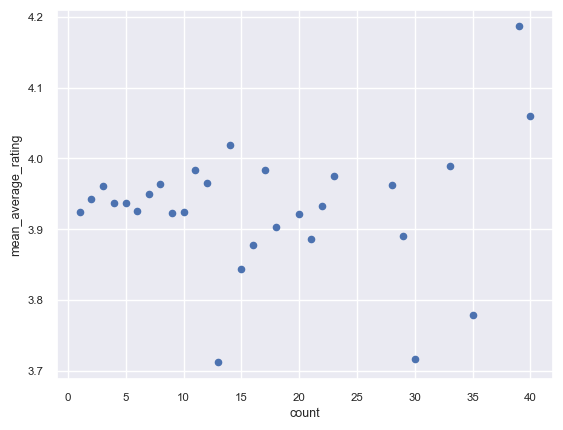

In [31]:
#We could think about creating a new column with the mean or median as an average rate
#However by looking at other number of publications by author, an obvious relation does not seem to be present.
#At least, there is not obvious linear relation
#For exemple, authors having more books in the dataset have not necessary a higher average rating.
temp = df.copy()
temp2 = temp[['authors','average_rating']].groupby('authors') \
    .agg({'authors':'size', 'average_rating':'mean'}) \
    .rename(columns={'authors':'count','average_rating':'mean_average_rating'}) \

temp2 = temp2.groupby('count') \
    .agg({'mean_average_rating':'mean'})
temp2.reset_index().plot(kind='scatter', x='count', y='mean_average_rating')

<bound method NDFrame.head of                                count  mean_average_rating
publisher                                                
10/18                              2             3.650000
1st Book Library                   1             3.580000
1st World Library                  1             4.180000
A & C Black (Childrens books)      1             4.400000
A Harvest Book/Harcourt  Inc.      1             4.070000
...                              ...                  ...
聯經出版事業股份有限公司                       2             4.400000
英文漢聲出版股份有限公司                       1             4.220000
角川書店 (Kadokawa Shoten)             2             3.815000
講談社                                6             4.283333
集英社                               12             4.237500

[2292 rows x 2 columns]>


<Axes: xlabel='count', ylabel='mean_average_rating'>

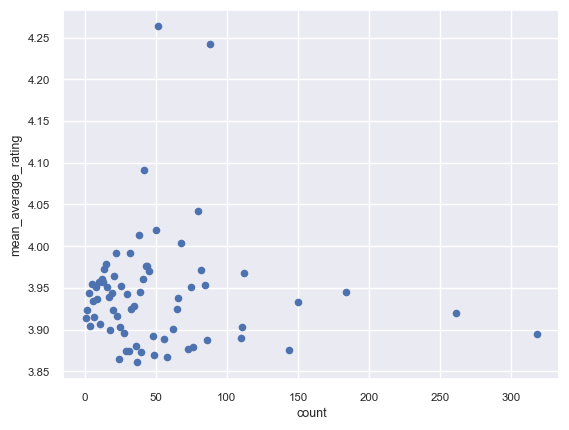

In [35]:
#It seems to be similar for the publishers
temp2 = temp[['publisher','average_rating']].groupby('publisher') \
    .agg({'publisher':'size', 'average_rating':'mean'}) \
    .rename(columns={'publisher':'count','average_rating':'mean_average_rating'}) \

print(temp2.head)

temp2 = temp2.groupby('count') \
    .agg({'mean_average_rating':'mean'})
result = pd.concat([df, temp2], axis=1, join="inner")

temp2.reset_index().plot(kind='scatter', x='count', y='mean_average_rating')

In [34]:
#how could we still add information embedded in the authors dimension ?
#There are thousands of unique authors. Therefore, hot encoding of all authors would not be appropriate.
#Therefore, we can try do add take into account information related to the author by using indirect related KPIs
#For example author_ratings_count or author_number_books

#create the KPIs columns
#authorsEmbededInfo = df[['authors','average_rating','ratings_count']].groupby('authors').agg({'authors':'size', 'average_rating':'mean','ratings_count':'sum'}).rename(columns={'authors':'author_number_books','average_rating':'author_books_avg_rating','ratings_count':'author_ratings_count'})
#authorsEmbededInfo = authorsEmbededInfo.reset_index()

#print(authorsEmbededInfo.describe())
#authorsEmbededInfo

#Add the new created columns into the dataset, in order to take into account information embeded in 'authors'
#df = pd.merge(df, authorsEmbededInfo, on='authors')

#Let's see the new correlation matrix
#High correlation between author_books_avg_rating and average_rating because it has been constructed on it for analysis purpose. It will not be used for modeling.
#mcorrel = df.select_dtypes(["float64","int64","int32"]).corr(method="pearson")

#fig, ax = plt.subplots(figsize=(5, 5))
#sns.set(font_scale=0.75)
#sns.heatmap(
#    mcorrel,
#    square=True,
#    ax=ax,
#    cmap="crest",
#    annot=True, fmt=".2f"
#)

#Let's also look at again the new pair relations

#col = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
#        'publicationYear','author_number_books','author_books_avg_rating','author_ratings_count',"catRating"]

#sns.pairplot(df[col],hue="catRating", corner=True) 

#### Categorizing the variable to be predicted 

###### An interesting exercise would be the prediction of the 'average_rating' but categorized into two groups, one for the highest scores and the other for its complement. The variable was previously categorized, and some graphs are shown below for a visual analysis of the possible relationships with the predictor variables.

c:\Users\Stefanny\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



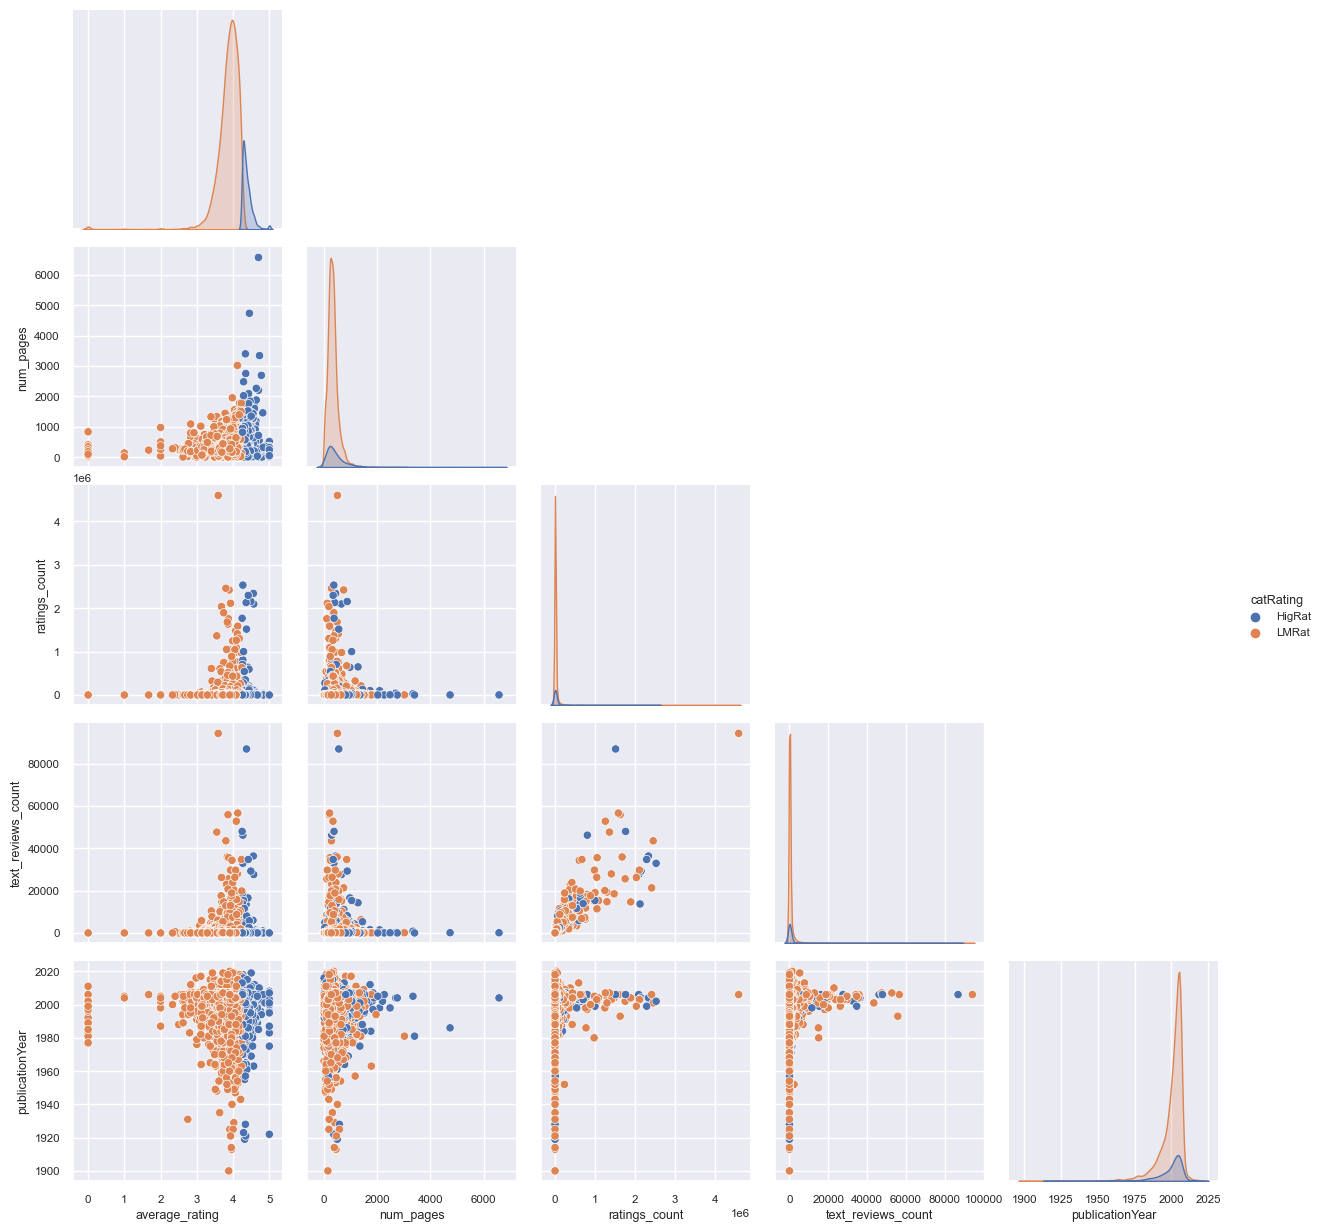

In [36]:
col = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
        'publicationYear',"catRating"]

sns.pairplot(df[col],hue="catRating", corner=True) 

## III. Modeling

### 3.1 Modeling - Preprocessing

In [18]:
 #Data of interest 
col = ['num_pages', 'text_reviews_count', #'ratings_count', 
        'publicationYear','language_code_grouped', 'catRating','average_rating']

dfmodel = df[col].copy()

#### 3.1.1 Handle outliers

In [19]:
#%%outliers

#The process of identifying outliers has many names in data mining and machine 
# learning such as outlier mining, outlier modeling and novelty detection and 
# anomaly detection.In his book "Outlier Analysis", Aggarwal provides a useful taxonomy
#  of outlier detection methods.

#one possibility:Delimit the variables using 3 standard deviations

columns =['num_pages','text_reviews_count'] #'ratings_count',

for c in columns:
    data_mean, data_std = np.mean(dfmodel[c]), np.std(dfmodel[c])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    dfmodel[c]= [upper if x > upper else x for x in df[c]]

dfmodel.describe()

,num_pages,text_reviews_count,publicationYear,average_rating
count,11127.000000,11127.000000,11127.000000,11127.000000
mean,331.004626,426.618096,2000.167520,3.933631
std,206.766439,1199.900322,8.248836,0.352445
min,0.000000,0.000000,1900.000000,0.000000
25%,192.000000,9.000000,1998.000000,3.770000
50%,299.000000,46.000000,2003.000000,3.960000
75%,416.000000,237.500000,2005.000000,4.135000
max,1059.726331,8270.037027,2020.000000,5.000000


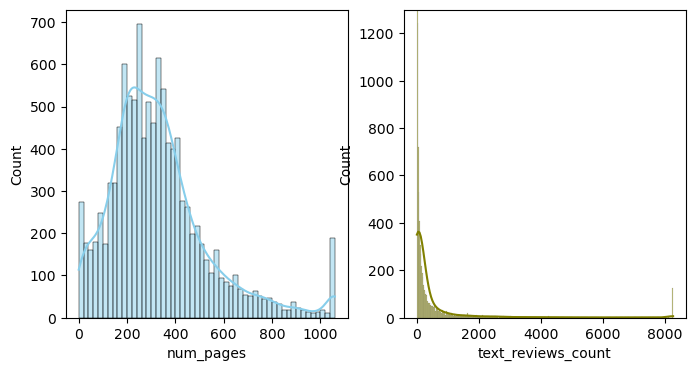

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(data=dfmodel, x="num_pages", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=dfmodel, x="text_reviews_count", kde=True, color="olive", ax=axs[1]).set_ylim(0, 1300)
#sns.histplot(data=dfmodel, x="ratings_count", kde=True, color="olive", ax=axs[2])
plt.show()

#### 3.1.2 Preprocessing for categorical case 

##### Rename categories

In [20]:
# Apply the function, to rename categories

dicCat = {"HigRat": "1",
        "LMRat": "0"}

dfmodel["catRating"] = dfmodel["catRating"].apply(lambda x: dicCat[x])


##### Split data and transform features

In [21]:
X = dfmodel[['num_pages', 'text_reviews_count', 'publicationYear','language_code_grouped']]
y = dfmodel.loc[:, "catRating"]

#split the data
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y, train_size=0.8, random_state=1, stratify=y
)

##### Encode target column

In [22]:
#Encode target column
label_encode = LabelEncoder()
label_encode.fit(y_train_cat)
y_train_cat = label_encode.transform(y_train_cat)
y_test_cat = label_encode.transform(y_test_cat)

In [23]:
#Compare samples
print(X_train_cat.describe())
print(X_test_cat.describe())

         num_pages  text_reviews_count  publicationYear
count  8901.000000         8901.000000      8901.000000
mean    331.180526          418.833914      2000.096057
std     207.366825         1184.566547         8.409738
min       0.000000            0.000000      1900.000000
25%     194.000000            9.000000      1998.000000
50%     298.000000           47.000000      2003.000000
75%     416.000000          232.000000      2005.000000
max    1059.726331         8270.037027      2020.000000
         num_pages  text_reviews_count  publicationYear
count  2226.000000         2226.000000      2226.000000
mean    330.301263          457.744335      2000.453279
std     204.392750         1259.145623         7.566385
min       0.000000            0.000000      1914.000000
25%     192.000000            9.000000      1999.000000
50%     300.000000           44.000000      2003.000000
75%     416.000000          254.000000      2005.000000
max    1059.726331         8270.037027      2017

##### Apply transformations

In [24]:
cont_ix = X_train_cat.select_dtypes(exclude=["object"]).columns
cat_ix = X_train_cat.select_dtypes(include=["object"]).columns
print(cont_ix)
print(cat_ix)

cont_pipeline = make_pipeline(
    RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
)

cat_pipeline = make_pipeline(OneHotEncoder(drop="first"))

preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_pipeline, cont_ix),
        ("cat", cat_pipeline, cat_ix),
    ]
)

dt = Pipeline(steps=[("preprocessor", preprocessor)])
dt.fit(X_train_cat)

X_train_cat_dt = dt.transform(X_train_cat)

#Final data set
var_list = list(dt.get_feature_names_out())
X_train_cat = pd.DataFrame(X_train_cat_dt, columns=var_list)

X_test_cat_dt = dt.transform(X_test_cat)
X_test_cat = pd.DataFrame(X_test_cat_dt, columns=var_list)

Index(['num_pages', 'text_reviews_count', 'publicationYear'], dtype='object')
Index(['language_code_grouped'], dtype='object')


#### 3.1.3 Preprocessing for regression case

##### Split data and transform features

In [25]:
#X = dfmodel[['num_pages', 'text_reviews_count', 'publicationYear','language_code_grouped']]
yCont = dfmodel.loc[:, "average_rating"]

#split the data
X_train, X_test, yCont_train, yCont_test = train_test_split(
   X, yCont, train_size=0.8, random_state=1
)

print(yCont.describe())
print(yCont_train.describe())
print(yCont_test.describe())

count    11127.000000
mean         3.933631
std          0.352445
min          0.000000
25%          3.770000
50%          3.960000
75%          4.135000
max          5.000000
Name: average_rating, dtype: float64
count    8901.000000
mean        3.930401
std         0.359168
min         0.000000
25%         3.770000
50%         3.960000
75%         4.130000
max         5.000000
Name: average_rating, dtype: float64
count    2226.000000
mean        3.946545
std         0.323928
min         0.000000
25%         3.780000
50%         3.960000
75%         4.140000
max         5.000000
Name: average_rating, dtype: float64


##### Apply transformations

In [26]:
cont_ix = X_train.select_dtypes(exclude=["object"]).columns
cat_ix = X_train.select_dtypes(include=["object"]).columns

cont_pipeline = make_pipeline(
    RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
)

cat_pipeline = make_pipeline(OneHotEncoder(drop="first"))

preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_pipeline, cont_ix),
        ("cat", cat_pipeline, cat_ix),
    ]
)

dt_cont = Pipeline(steps=[("preprocessor", preprocessor)])
dt_cont.fit(X_train)

X_train_dt = dt_cont.transform(X_train)

#Final data set
var_list = list(dt_cont.get_feature_names_out())
X_train = pd.DataFrame(X_train_dt, columns=var_list)

X_test_dt = dt_cont.transform(X_test)
X_test = pd.DataFrame(X_test_dt, columns=var_list)

### 3.2 Modeling - Regression

In [27]:
#Modeling - Polynomial Regression
# the default "include_bias=True" adds a feature that's constantly 1
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
X_poly_train = poly.transform(X_train)
X_poly_test = poly.transform(X_test)

print("X.shape: {}".format(X.shape))
print("X_train.shape: {}".format(X_train.shape))
print("X_poly_train.shape: {}".format(X_poly_train.shape))
print("Entries of X:\n{}".format(X[:5]))
print("Entries of X_train:\n{}".format(X_train[:5]))
print("Entries of X_poly_train:\n{}".format(X_poly_train[:5]))
print("Polynomial feature names:\n{}".format(poly.get_feature_names_out()))

X.shape: (11127, 4)
X_train.shape: (8901, 8)
X_poly_train.shape: (8901, 44)
Entries of X:
          num_pages  text_reviews_count  publicationYear language_code_grouped
bookID                                                                        
1        652.000000         8270.037027             2006                   eng
2        870.000000         8270.037027             2004                   eng
4        352.000000          244.000000             2003                   eng
5        435.000000         8270.037027             2004                   eng
8       1059.726331          164.000000             2004                   eng
Entries of X_train:
   cont__num_pages  cont__text_reviews_count  cont__publicationYear  \
0        -0.484305                 -0.161017               0.285714   
1         3.406845                 -0.156780               0.285714   
2         0.560538                 -0.046610               0.000000   
3        -0.412556                 -0.173729         

[0.03620711 0.01337107 0.01771058 0.02860847 0.03215693]
LinR: 0.025611 (0.008676)
[0.03617387 0.01342001 0.01775312 0.02873158 0.03216971]
RGE: 0.025650 (0.008657)
[0.03560703 0.01364119 0.0178078  0.02932334 0.03197656]
RGE10: 0.025671 (0.008466)
[0.03620433 0.0133763  0.0177154  0.02862157 0.03215874]
RGE01: 0.025615 (0.008674)
[-1.03358245e-04 -8.09026739e-05 -4.99340010e-04 -2.93282250e-05
 -1.63077672e-03]
LSO: -0.000469 (0.000605)
[0.02595584 0.01345026 0.01562945 0.0246938  0.02819274]
LSO001: 0.021584 (0.005900)
[0.03660283 0.01377125 0.01840811 0.029156   0.03247435]
LSO00001: 0.026083 (0.008619)
[0.03620711 0.01337107 0.01771058 0.02860847 0.03215693]
polyLR: 0.025611 (0.008676)
[0.03015825 0.00152947 0.01123452 0.02241871 0.02838097]
LSVR: 0.018744 (0.010857)
[0.04014075 0.035153   0.02024846 0.05311785 0.04558355]
RFReg: 0.038849 (0.011048)


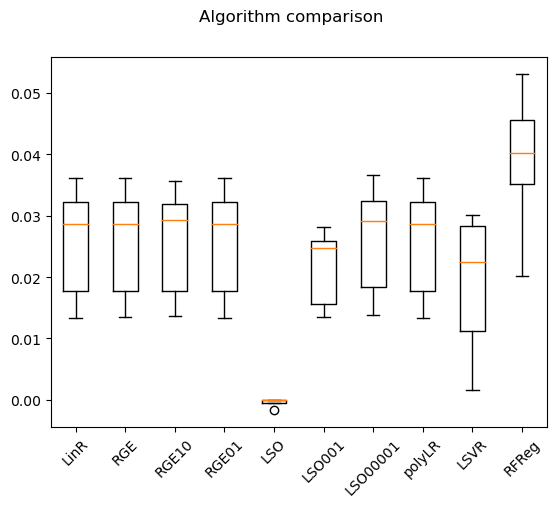

In [28]:
#Model comparison
models = []
models.append(("LinR", LinearRegression()))
#models.append(("KNN", KNeighborsRegressor (n_neighbors=2)))
models.append(("RGE", Ridge(alpha=1)))
models.append(("RGE10", Ridge(alpha=10)))
models.append(("RGE01", Ridge(alpha=0.1)))
models.append(("LSO", Lasso(alpha=1)))
models.append(("LSO001", Lasso(alpha=0.01, max_iter=100000)))
models.append(("LSO00001", Lasso(alpha=0.0001, max_iter=100000)))
models.append(("polyLR", LinearRegression()))
models.append(("LSVR", LinearSVR(max_iter=2000)))
models.append(("RFReg", RandomForestRegressor(max_depth=2, random_state=0)))

results = []
names = []


for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    if name=='polyLinreg':
        cv_results = cross_val_score(
        model, X_poly_train, yCont_train, cv=kfold, n_jobs=-1
        )
    else:
        cv_results = cross_val_score(
        model, X_train, yCont_train, cv=kfold,  n_jobs=-1
        )
    print(cv_results)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot to compare
fig = plt.figure()
fig.suptitle("Algorithm comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45)
plt.show()

###### As expected above, regression Modeling do not perform well, even if we add some non linearity in the modeling (e.g. polynomial linear regression, etc)

In [44]:
#Modeling - Linear regression model
linReg = LinearRegression().fit(X_train, yCont_train)
print("Linear Training set score: {:.3f}".format(linReg.score(X_train,yCont_train)))
print("Linear Test set score: {:.3f}".format(linReg.score(X_test,yCont_test)))

Linear Training set score: 0.028
Linear Test set score: 0.022


In [45]:
#Modeling - KNN regression model
KNN = KNeighborsRegressor (n_neighbors=7)
KNN.fit(X_train, yCont_train)
print("Linear Training set score: {:.3f}".format(KNN.score(X_train,yCont_train)))
print("Linear Test set score: {:.3f}".format(KNN.score(X_test,yCont_test)))

Linear Training set score: 0.192
Linear Test set score: -0.068


In [46]:
#Modeling - Ridge Linear Regression
ridge= Ridge().fit(X_train, yCont_train)
print("Ridge with alpha=1")
print("Training set score: {:.2f}".format(ridge.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, yCont_test)))

print("\nRidge with alpha=10")
ridge10= Ridge(alpha=10).fit(X_train, yCont_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, yCont_test)))

ridge01= Ridge(alpha=0.1).fit(X_train, yCont_train)
print("\nRidge with alpha=0.1")
print("Training set score: {:.2f}".format(ridge01.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, yCont_test)))

Ridge with alpha=1
Training set score: 0.03
Test set score: 0.02

Ridge with alpha=10
Training set score: 0.03
Test set score: 0.02

Ridge with alpha=0.1
Training set score: 0.03
Test set score: 0.02


In [47]:
#Modeling - Lasso Linear Regression (Least Absolute Shrinkage And Selection Operator)
lasso = Lasso().fit(X_train, yCont_train)
print("Lasso with alpha=1")
print("Training set score: {:.2f}".format(lasso.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, yCont_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ !=0)))

#Lasso with less regularisation
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, yCont_train)
print("\nLasso with alpha=0.01")
print("Training set score: {:.2f}".format(lasso001.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, yCont_test)))
print("Number of features used: {}".format(np.sum(lasso001.coef_ !=0)))

#Lasso with even less regularisation
lasso00001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, yCont_train)
print("\nLasso with alpha=0.0001")
print("Training set score: {:.2f}".format(lasso00001.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(lasso00001.score(X_test, yCont_test)))
print("Number of features used: {}".format(np.sum(lasso00001.coef_ !=0)))

Lasso with alpha=1
Training set score: 0.00
Test set score: -0.00
Number of features used: 0

Lasso with alpha=0.01
Training set score: 0.02
Test set score: 0.01
Number of features used: 3

Lasso with alpha=0.0001
Training set score: 0.03
Test set score: 0.02
Number of features used: 7


In [48]:
poly_linreg = LinearRegression().fit(X_poly_train, yCont_train)
print("Poly Training set score: {:.3f}".format(poly_linreg.score(X_poly_train,yCont_train)))
print("Poly Test set score: {:.3f}".format(poly_linreg.score(X_poly_test,yCont_test)))

Poly Training set score: 0.041
Poly Test set score: 0.033


In [49]:
linSVR = LinearSVR(max_iter=2000)
linSVR.fit(X_train, yCont_train)
print("SGD linear regressor Training set score: {:.3f}".format(linSVR.score(X_train,yCont_train)))
print("SGD linear regressor Test set score: {:.3f}".format(linSVR.score(X_test,yCont_test)))

c:\Users\Stefanny\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SGD linear regressor Training set score: 0.021
SGD linear regressor Test set score: 0.024


c:\Users\Stefanny\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [50]:
RFReg = RandomForestRegressor(max_depth=2, random_state=0)
RFReg.fit(X_train, yCont_train)
print("Random Forest regressor Training set score: {:.3f}".format(RFReg.score(X_train,yCont_train)))
print("Random Forest regressor Test set score: {:.3f}".format(RFReg.score(X_test,yCont_test)))

Random Forest regressor Training set score: 0.048
Random Forest regressor Test set score: 0.019


### 3.3 Modeling - Classification 

LR: 0.584035 (0.018987)
LDA: 0.584738 (0.018854)
KNN: 0.591961 (0.011164)
RF: 0.621182 (0.019881)
CART: 0.537849 (0.011461)
NB: 0.623986 (0.022709)
SVM: 0.647221 (0.020236)


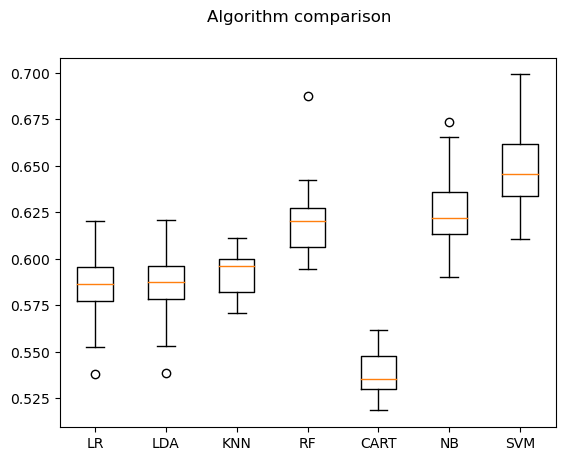

In [29]:
#base line
models = []
models.append(("LR", LogisticRegression(solver="lbfgs", class_weight="balanced")))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("RF",RandomForestClassifier(n_estimators=100, random_state=1, class_weight="balanced"),))
models.append(("CART", DecisionTreeClassifier(class_weight="balanced")))
models.append(("NB", GaussianNB()))
models.append(("SVM", SVC(class_weight="balanced")))


results = []
names = []
scoring = "roc_auc"

for name, model in models:
    kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    cv_results = cross_val_score(
        model, X_train_cat, y_train_cat, cv=kfold, scoring=scoring, n_jobs=-1
    )
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot to compare
fig = plt.figure()
fig.suptitle("Algorithm comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

###### We get better results by using classification models. Repeated Stratified cross validation with different randomization in each repetition ends up with Random Forest as the best model.

In [30]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

#hyperparameters
svm = SVC(class_weight="balanced")

#grid_random = GridSearchCV(svc,param_grid,refit=True,verbose=2)
grid_random = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=50,
    n_jobs=-1,
)

grid_random.fit(X_train_cat, y_train_cat)

print(grid_random.best_estimator_)
print("Best parameters of SVM after grid search and cross validations are:\n {}\n".format(grid_random.best_estimator_))

#Fitting 5 folds for each of 48 candidates, totalling 240 fits
#SVC(C=1, class_weight='balanced', gamma=0.01, kernel='poly')
#Best parameters of SVM after grid search and cross validations are:
#SVC(C=1, class_weight='balanced', gamma=0.01, kernel='poly')


c:\Users\Stefanny\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 48 candidates, totalling 240 fits
SVC(C=1, class_weight='balanced', gamma=0.01, kernel='poly')
Best parameters of SVM after grid search and cross validations are:
 SVC(C=1, class_weight='balanced', gamma=0.01, kernel='poly')



In [31]:

print("Corresponding best cross validations score is:\n{}\n".format(grid_random.best_score_))

print("Corresponding Test sest score is:\n{}".format(grid_random.score(X_test_cat, y_test_cat)))

Corresponding best cross validations score is:
0.8613639604060337

Corresponding Test sest score is:
0.8616352201257862


#Let's focus on Random Forest then and use a Grid search for hyperparameters in addition to the cross validation

#WARNING : it can take up to 50 mn to run with stop=2000
#WARNING : it can take up to 10 mn to run with stop=101
n_estimators = [int(x) for x in np.linspace(start=100, stop=101, num=20)]
max_features = ["log2", "sqrt"]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}
random_grid

#hyperparameters random search
rf = RandomForestClassifier(class_weight="balanced")

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=50,
    n_jobs=-1,
)

rf_random.fit(X_train_cat, y_train_cat)

In [744]:
#Results of hyperparameters random search 
print("Best parameters of Random Forest after grid search and cross validations are:\n {}\n".format(rf_random.best_params_))
#results with stop = 2000 without author and publisher
#Fitting 5 folds for each of 100 candidates, totalling 500 fits
#{'n_estimators': 1500,
# 'min_samples_split': 2,
# 'min_samples_leaf': 1,
# 'max_features': 'log2',
# 'max_depth': 80,
# 'bootstrap': True}

print("Corresponding best cross validations score is:\n{}\n".format(rf_random.best_score_))

print("Corresponding Test sest score is:\n{}".format(rf_random.score(X_test_cat, y_test_cat)))

Best parameters of Random Forest after grid search and cross validations are:
 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}

Corresponding best cross validations score is:
0.873947536102051

Corresponding Test sest score is:
0.8724168912848158


In [745]:
#The test score is the most relevant to check to evaluate the model generalization.

In [746]:
# prediction
##???
##print(rf_random.best_params_.
      ##predict_proba(X_test))


RF = RandomForestClassifier(
    n_estimators=rf_random.best_params_["n_estimators"],
    min_samples_split=rf_random.best_params_["min_samples_split"],
    min_samples_leaf=rf_random.best_params_["min_samples_leaf"],
    max_features=rf_random.best_params_["max_features"],
    max_depth=rf_random.best_params_["max_depth"],
    bootstrap=rf_random.best_params_["bootstrap"],
    random_state=50,
    ##??? random_state=1,
    class_weight="balanced",
)
RF.fit(X_test_cat, y_train_cat)
yhatRF = RF.predict_proba(X_test_cat)
print(yhatRF)

[[0.89 0.11]
 [0.92 0.08]
 [0.98 0.02]
 ...
 [0.76 0.24]
 [0.86 0.14]
 [0.44 0.56]]


Feature: 0, Score: 0.08152
Feature: 1, Score: 0.22933
Feature: 2, Score: 0.28177
Feature: 3, Score: 0.22904
Feature: 4, Score: 0.15198
Feature: 5, Score: 0.00432
Feature: 6, Score: 0.00271
Feature: 7, Score: 0.00739
Feature: 8, Score: 0.00665
Feature: 9, Score: 0.00529


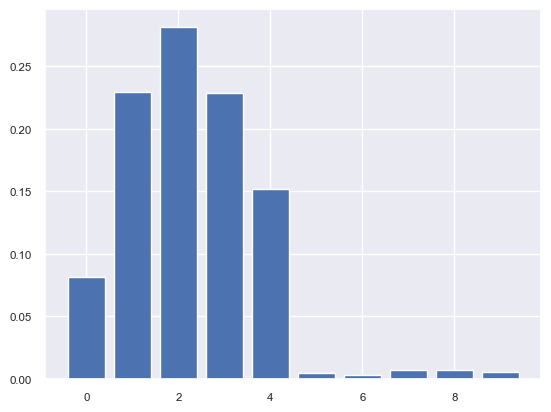

In [747]:
# variable importances
importRF = RF.feature_importances_  # also known as the Gini importance.
for i, v in enumerate(importRF):
    print("Feature: %0d, Score: %.5f" % (i, v))

plt.bar([x for x in range(len(importRF))], importRF)
plt.show()


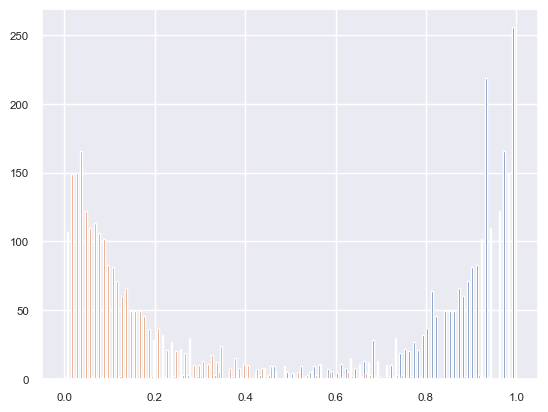

In [748]:

# Histogram of probabilities 
plt.hist(yhatRF, bins=100)
plt.show()


#### Model evaluation

In [749]:
y_pred = yhatRF[:, 1] #positive class predicted (probabilities)

roc_display = RocCurveDisplay.from_estimator(RF, X_test_cat, y_test_cat)
plt.close()
pr_display = PrecisionRecallDisplay.from_estimator(RF, X_test_cat, y_test_cat)
plt.close()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)


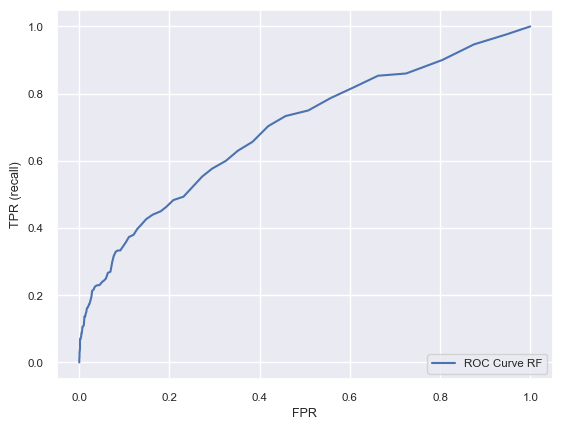

In [750]:

#function to define the variable in terms of category, based on a threshold.
def to_labels(ped,t):
    a = np.where(ped>t, 1, 0)
    return a

#potential thresholds
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold: F2-measure Less weight in precision, more weight in recall.
scoresfbetaXGB = [
    fbeta_score(y_test_cat, to_labels(y_pred, t), average="binary", beta=2)
    for t in thresholds
]

# Threshold and fbeta2_score selected
ixscoresfbetaXGB = np.argmax(scoresfbetaXGB)
print(
    "Threshold=%.3f, fbeta2_score=%.5f"
    % (thresholds[ixscoresfbetaXGB], scoresfbetaXGB[ixscoresfbetaXGB])
)

#result: Threshold=0.113, fbeta2_score=0.37500

In [751]:
#Apply the Threshold=0.113
y_pred_class = to_labels(y_pred, 0.113)

print(classification_report(y_test_cat, y_pred_class))
print("ROC AUC score:", roc_auc_score(y_test_cat, y_pred_class))


confusion_matrix is:
[[1894   32]
 [ 252   48]]


In [ ]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test_cat, y_pred_class, labels=RF.classes_,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )

    print(title)
    print(disp.confusion_matrix)